# ASL Alphabet Image Classification with PyTorch

## Data Source
The data used in this project comes from kaggle datasets: https://www.kaggle.com/datasets/grassknoted/asl-alphabet/data </br>
The dataset contains images of ASL Alphabet hand gestures representing the letters + 3 signs (nothing, space, delete).

## The main goal
The main goal of this project is to provide a fully-trained neural network model in PyTorch that will be able to correctly classify given image of hand gesture to ASL Alphabet sign.

## Project steps
- import ASL Alphabet dataset from Kaggle
- preprocess the data
- create a dataset class using PyTorch
- create dataloaders for loading the data with batches
- set up a CNN model in PyTorch
- train the created model
- validate the model performance on validation data
- test the model on test data
- display the plot for loss and accuracy of the model

## Further development
The model is just one of the steps of a bigger project. </br>
It will be used to classify the frames from a webcam or video in real-time.


## Import ASL Alphabet dataset from Kaggle
Opendatasets python library is a great choice for importing the datasets from Kaggle.

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Rimpy9
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary

from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


The dataset is divided into two files: asl_alphabet_test and asl_alphabet_train.
</br>
The following code loads the data from asl_alphabet_train to a pandas dataframe and will be divided into train, test and validation dataframes.

In [3]:
image_paths = []
labels = []

for label in os.listdir("/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train"):
  for image in os.listdir(f"/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/{label}/"):
    image_paths.append(f"/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/{label}/{image}")
    labels.append(label)

df = pd.DataFrame(zip(image_paths, labels), columns=["image_path", "label"])
print(df["label"].unique())
df.head()

['O' 'del' 'C' 'K' 'D' 'H' 'nothing' 'N' 'U' 'G' 'space' 'W' 'A' 'S' 'V'
 'X' 'Z' 'T' 'I' 'B' 'F' 'L' 'M' 'R' 'P' 'E' 'Y' 'J' 'Q']


,image_path,label
0,/content/asl-alphabet/asl_alphabet_train/asl_a...,O
1,/content/asl-alphabet/asl_alphabet_train/asl_a...,O
2,/content/asl-alphabet/asl_alphabet_train/asl_a...,O
3,/content/asl-alphabet/asl_alphabet_train/asl_a...,O
4,/content/asl-alphabet/asl_alphabet_train/asl_a...,O


## Preprocess the data
Using label encoding to change the characters from label column into integers.

In [4]:
original_df = df.copy()

#all possible categories in 'label' column
characters = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "nothing", "space", "del"]

df["label"] = df["label"].apply(lambda char: characters.index(char) if char in characters else None)

print(df["label"].unique())
print(original_df["label"].unique())
df.head()

[14 28  2 10  3  7 26 13 20  6 27 22  0 18 21 23 25 19  8  1  5 11 12 17
 15  4 24  9 16]
['O' 'del' 'C' 'K' 'D' 'H' 'nothing' 'N' 'U' 'G' 'space' 'W' 'A' 'S' 'V'
 'X' 'Z' 'T' 'I' 'B' 'F' 'L' 'M' 'R' 'P' 'E' 'Y' 'J' 'Q']


,image_path,label
0,/content/asl-alphabet/asl_alphabet_train/asl_a...,14
1,/content/asl-alphabet/asl_alphabet_train/asl_a...,14
2,/content/asl-alphabet/asl_alphabet_train/asl_a...,14
3,/content/asl-alphabet/asl_alphabet_train/asl_a...,14
4,/content/asl-alphabet/asl_alphabet_train/asl_a...,14


train_test_split divides the dataset into train, test and validation datasets.

In [5]:
X = df["image_path"].values
y = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(60900,)
(13050,)
(13050,)


Before loading the data some transformation will be applied to images. </br>
Their size will be 200x200, they will be transformed into PyTorch's tensors, and their pixels will be normalized.

In [6]:
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Create a dataset class

The following class applies the above transformations to images and sets both labels and images to given device.

In [7]:
class ASLAlbhabetDataset(Dataset):
  def __init__(self, image_paths, labels, transform=None):
    # self.image_paths = image_paths.tolist() if isinstance(image_paths, pd.Series) else image_paths
    # self.labels = torch.tensor(labels.tolist() if isinstance(labels, pd.Series) else labels)
    self.image_paths = image_paths
    self.labels = torch.tensor(labels).to(device)
    self.transforms = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    label = self.labels[idx]

    image = Image.open(image_path).convert("RGB")

    if self.transforms:
      image = self.transforms(image).to(device)

    return image, label

In [8]:
train_dataset = ASLAlbhabetDataset(image_paths=X_train, labels=y_train, transform=transform)
test_dataset = ASLAlbhabetDataset(image_paths=X_test, labels=y_test, transform=transform)
val_dataset = ASLAlbhabetDataset(image_paths=X_val, labels=y_val, transform=transform)

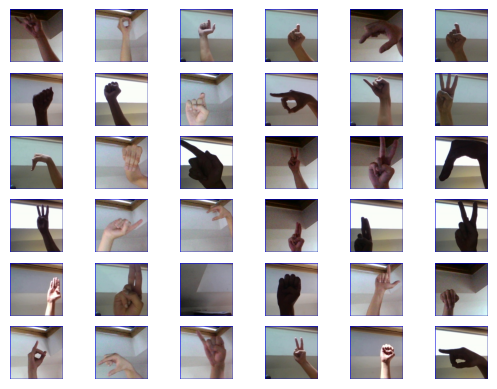

In [9]:
n_rows = 6
n_cols = 6

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
    axarr[row, col].imshow(image)
    axarr[row, col].axis("off")

plt.show()

In [10]:
LR = 0.001 #learning rate
BATCH_SIZE = 32
EPOCHS = 20

## Create dataloaders

Dataloaders allow the data to be loaded in batches.

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Set up CNN model

This CNN model has been designed for the project and consists of:

-Three convolutional layers: Each layer includes a convolution operation, a non-linear ReLU activation function, and a max pooling layer.</br>

-A flatten layer (Flatten): Transforms the multi-dimensional output from the convolutional layers into a one-dimensional tensor.</br>

-A fully-connected layer (Linear): Contains a linear layer, a ReLU activation function, and a dropout layer to reduce the risk of overfitting.</br>

-An output layer (Linear): This is a linear layer that produces the final output with a size equal to the number of classes.

In [12]:
class CNNModel(nn.Module):
  def __init__(self, num_classes, input_height, input_width):
    super().__init__()

    input_channels = 3

    self.conv1 = nn.Sequential(
        nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.flatten = nn.Flatten()

    self._to_linear = self._calculate_flatten_size(input_height=input_height, input_width=input_width)

    self.fc = nn.Sequential(
        nn.Linear(self._to_linear, 128),
        # nn.Linear(128 * 25 * 25, 128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )

    self.output = nn.Linear(128, num_classes)

  def _calculate_flatten_size(self, input_height, input_width):
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, input_height, input_width)
            x = self.conv1(dummy_input)
            x = self.conv2(x)
            x = self.conv3(x)
            return torch.prod(torch.tensor(x.shape[1:])).item()

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.flatten(x)
    x = self.fc(x)
    x = self.output(x)

    return x

In [13]:
model = CNNModel(len(df["label"].unique()), input_height=200, input_width=200).to(device)

print(len(df["label"].unique()))

summary(model, input_size=(3, 200, 200))

29
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 200, 200]             896
              ReLU-2         [-1, 32, 200, 200]               0
         MaxPool2d-3         [-1, 32, 100, 100]               0
            Conv2d-4         [-1, 64, 100, 100]          18,496
              ReLU-5         [-1, 64, 100, 100]               0
         MaxPool2d-6           [-1, 64, 50, 50]               0
            Conv2d-7          [-1, 128, 50, 50]          73,856
              ReLU-8          [-1, 128, 50, 50]               0
         MaxPool2d-9          [-1, 128, 25, 25]               0
          Flatten-10                [-1, 80000]               0
           Linear-11                  [-1, 128]      10,240,128
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

## Train model and validate its performance

In [17]:
history = {
    'train_loss': [],
    'val_loss': [],
    'train_accuracy': [],
    'val_accuracy': []
}

patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(EPOCHS):
  train_loss = 0
  train_accuracy = 0

  val_loss = 0
  val_accuracy = 0

  #TRAINING
  model.train()
  for images, labels in train_dataloader:
    outputs = model(images)

    #BATCH LOSS
    batch_loss = criterion(outputs, labels)
    train_loss += batch_loss.item()

    #BATCH ACCURACY
    batch_accuracy = (torch.argmax(outputs, axis=1) == labels).sum()
    train_accuracy += batch_accuracy.item()

    #BACKPROPAGATION
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  #VALIDATING
  model.eval()
  with torch.no_grad():
    for images, labels in val_dataloader:
      outputs = model(images)

      #BATCH LOSS
      batch_loss = criterion(outputs, labels)
      val_loss += batch_loss.item()

      #BATCH ACCURACY
      batch_accuracy = (torch.argmax(outputs, axis=1) == labels).sum()
      val_accuracy += batch_accuracy.item()

  avg_train_loss = round(train_loss / len(train_dataloader), 4)
  avg_train_accuracy = round(train_accuracy / len(train_dataset), 4)

  avg_val_loss = round(val_loss / len(val_dataloader), 4)
  avg_val_accuracy = round(val_accuracy / len(val_dataset), 4)

  history['train_loss'].append(avg_train_loss)
  history['train_accuracy'].append(avg_train_accuracy)

  history['val_loss'].append(avg_val_loss)
  history['val_accuracy'].append(avg_val_accuracy)

  print(f"Epoch {epoch+1}/{EPOCHS}")
  print(f"Train Loss: {round(train_loss / len(train_dataloader), 4)}, Train Accuracy: {round(train_accuracy / len(train_dataset), 4)}")
  print(f"Val Loss:   {round(val_loss / len(val_dataloader), 4)}, Val Accuracy:   {round(val_accuracy / len(val_dataset), 4)}")
  print("-" * 40)

  if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
  else:
      epochs_no_improve += 1
      if epochs_no_improve == patience:
          print(f"Early stopping triggered after {epoch+1} epochs!")
          break

Epoch 1/20
Train Loss: 0.8673, Train Accuracy: 0.7141
Val Loss:   0.1801, Val Accuracy:   0.942
----------------------------------------
Epoch 2/20
Train Loss: 0.2409, Train Accuracy: 0.9154
Val Loss:   0.0841, Val Accuracy:   0.974
----------------------------------------
Epoch 3/20
Train Loss: 0.1499, Train Accuracy: 0.9481
Val Loss:   0.0575, Val Accuracy:   0.982
----------------------------------------
Epoch 4/20
Train Loss: 0.1094, Train Accuracy: 0.962
Val Loss:   0.026, Val Accuracy:   0.9926
----------------------------------------
Epoch 5/20
Train Loss: 0.0844, Train Accuracy: 0.9712
Val Loss:   0.029, Val Accuracy:   0.99
----------------------------------------
Epoch 6/20
Train Loss: 0.0742, Train Accuracy: 0.9752
Val Loss:   0.021, Val Accuracy:   0.9939
----------------------------------------
Epoch 7/20
Train Loss: 0.0603, Train Accuracy: 0.9793
Val Loss:   0.0215, Val Accuracy:   0.993
----------------------------------------
Epoch 8/20
Train Loss: 0.0556, Train Accurac

## Test the model on test data

In [18]:
with torch.no_grad():
  test_loss = 0
  test_accuracy = 0

  for images, labels in test_dataloader:
    outputs = model(images)

    #BATCH LOSS
    batch_loss = criterion(outputs, labels)
    test_loss += batch_loss.item()

    #BATCH ACCURACY
    batch_accuracy = (torch.argmax(outputs, axis=1) == labels).sum()
    test_accuracy += batch_accuracy.item()

  print(f"Loss: {round(test_loss / len(test_dataloader), 4)}")
  print(f"Accuracy: {round(test_accuracy / len(test_dataset), 4)}")

Loss: 0.0193
Accuracy: 0.9966


## Plot the loss and accuracy of trained model

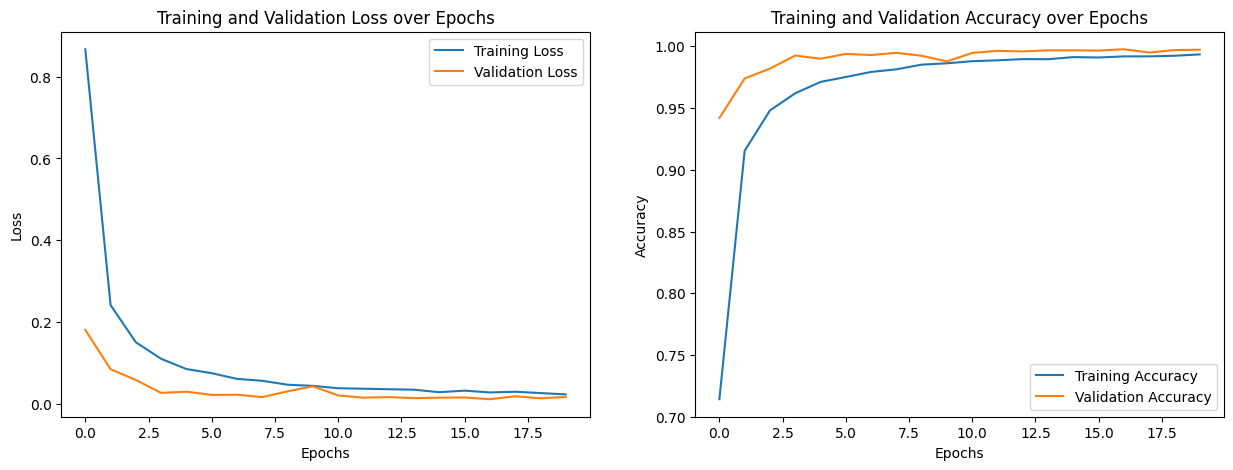

In [19]:
fix, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axis[0].plot(history['train_loss'], label='Training Loss')
axis[0].plot(history['val_loss'], label='Validation Loss')
axis[0].set_title('Training and Validation Loss over Epochs')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(history['train_accuracy'], label='Training Accuracy')
axis[1].plot(history['val_accuracy'], label='Validation Accuracy')
axis[1].set_title('Training and Validation Accuracy over Epochs')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()

plt.show()

### Loss plot
A validation loss follows a close trend to the training loss.</br>
The gap between the training and validation loss is small and consistent throughout the training process. This is a good sign that the model's performance on unseen data is close to its performance on the training data.

### Accuracy plot
The training accuracy and validation accuracy closely follow each other. The model looks pretty stable and reliable.

In [20]:
save_path = 'trained_model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model weights saved successfully to: {save_path}")

Model weights saved successfully to: trained_model.pth
